In [18]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'
#%load_ext itikz

#%matplotlib widget
#import ipywidgets as widgets
#from ipywidgets import *
#from ipywidgets.embed import embed_minimal_html

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

## buffer

the simplest circuit to begin with is a voltage buffer. while buffers with opamps are relatively easy, with the cmos chips the input and output impedence are important. 

The gain of a cmos buffer is

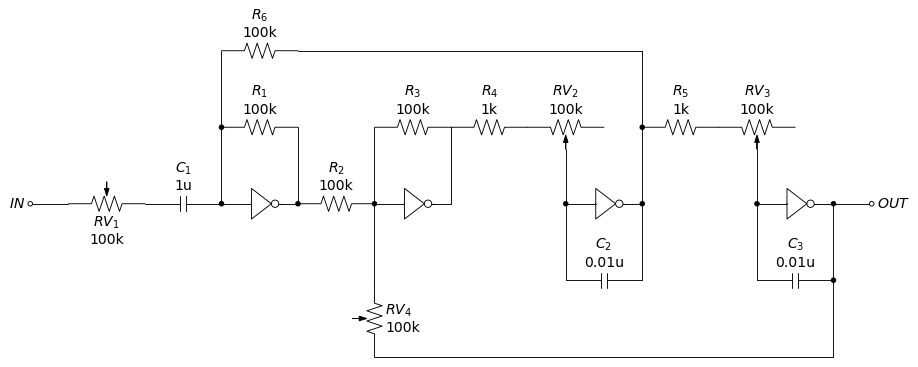

In [19]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot(open=True, lftlabel='$IN$'))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Potentiometer(label="$RV_1$\n100k"))
d.add(elm.Capacitor(label="$C_1$\n1u"))
N1 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_2$\n100k'))
N2 = d.add(logic.Not)
d.add(elm.Line('up', l=d.unit))
R3 = d.add(elm.Resistor('left', label='$R_3$\n100k'))
d.add(elm.Line('down', l=d.unit))
d.add(elm.Dot())

d.add(elm.Dot(at=N1.start))
d.add(elm.Line("up", l=d.unit))
R1 = d.add(elm.Resistor('right', label='$R_1$\n100k'))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Dot())

d.add(elm.Resistor("right", at=R3.start, label='$R_4$\n1k'))
RV2 = d.add(elm.Potentiometer("right", toplabel="$RV_2$\n100k", flip=True))
d.add(elm.Line("down", toy=N1.end, at=RV2.tap))
N3 = d.add(logic.Not("right"))
d.add(elm.Line("up", l=d.unit))
R5 = d.add(elm.Resistor("right", label='$R_5$\n1k'))
RV3 = d.add(elm.Potentiometer("right", toplabel="$RV_3$\n100k", flip=True))
d.add(elm.Line("down", toy=N1.end, at=RV3.tap))
N4 = d.add(logic.Not("right"))
d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Dot(open=True, rgtlabel="$OUT$"))

d.add(elm.Dot(at=R5.start))
d.add(elm.Line("up", l=d.unit))
d.add(elm.Line("left", tox=R1.end))
d.add(elm.Resistor(label="$R_6$\n100k"))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Dot())

d.add(elm.Dot(at=N3.start))
d.add(elm.Line("down"))
d.add(elm.Capacitor("right", label="$C_2$\n0.01u"))
d.add(elm.Line("up"))
d.add(elm.Dot())

d.add(elm.Dot(at=N4.start))
d.add(elm.Line("down"))
C3 = d.add(elm.Capacitor("right", label="$C_3$\n0.01u"))
d.add(elm.Line("up"))
d.add(elm.Dot())

d.add(elm.Dot(at=C3.end))
d.add(elm.Line("down"))
d.add(elm.Line("left", tox=N2.start))
d.add(elm.Potentiometer("up", label="$RV_4$\n100k"))
d.add(elm.Line("up", toy=N2.start))

d.draw()

In [20]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)
circuit.X('4', '4069UB', 'gate_in_4', 'gate_out_4', '+5V', circuit.gnd)

circuit.R("v1", 'IN', 'rv1_out', 47@u_kΩ)
circuit.C(1, 'rv1_out', 'gate_in_1', 1@u_uF)

circuit.R("1", 'gate_in_1', 'gate_out_1', 100@u_kΩ)
circuit.R("2", 'gate_out_1', 'gate_in_2', 100@u_kΩ)
circuit.R("3", 'gate_in_2', 'gate_out_2', 100@u_kΩ)
circuit.R("4", 'gate_out_2', 'R4out', 1@u_kΩ)
circuit.R("v2", 'R4out', 'gate_in_3', 50@u_kΩ)
circuit.R("5", 'gate_out_3', 'R5out', 1@u_kΩ)
circuit.R("v3", 'R5out', 'gate_in_4', 50@u_kΩ)

circuit.C(2, 'gate_in_3', 'gate_out_3', 0.01@u_uF)
circuit.C(3, 'gate_in_4', 'gate_out_4', 0.01@u_uF)

circuit.R("v4", 'gate_out_4', 'gate_in_2', 47@u_kΩ)
circuit.R(6, 'gate_out_3', 'gate_in_1', 100@u_kΩ)

print(circuit)


.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 5V SIN(0 5V 1k)
X1 gate_in_1 gate_out_1 +5V 0 4069UB
X2 gate_in_2 gate_out_2 +5V 0 4069UB
X3 gate_in_3 gate_out_3 +5V 0 4069UB
X4 gate_in_4 gate_out_4 +5V 0 4069UB
Rv1 IN rv1_out 47kOhm
C1 rv1_out gate_in_1 1uF
R1 gate_in_1 gate_out_1 100kOhm
R2 gate_out_1 gate_in_2 100kOhm
R3 gate_in_2 gate_out_2 100kOhm
R4 gate_out_2 R4out 1kOhm
Rv2 R4out gate_in_3 50kOhm
R5 gate_out_3 R5out 1kOhm
Rv3 R5out gate_in_4 50kOhm
C2 gate_in_3 gate_out_3 0.01uF
C3 gate_in_4 gate_out_4 0.01uF
Rv4 gate_out_4 gate_in_2 47kOhm
R6 gate_out_3 gate_in_1 100kOhm



In [21]:
buffer_data_lp = []
for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
    circuit.Rv2.resistance = r
    circuit.Rv3.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data_lp.append(np.array(analysis_ac['gate_out_4']))

In [22]:
buffer_data_hp = []
for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
    circuit.Rv2.resistance = r
    circuit.Rv3.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data_hp.append(np.array(analysis_ac['gate_out_2']))

In [23]:
buffer_data_bp = []
for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
    circuit.Rv2.resistance = r
    circuit.Rv3.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data_bp.append(np.array(analysis_ac['gate_out_3']))

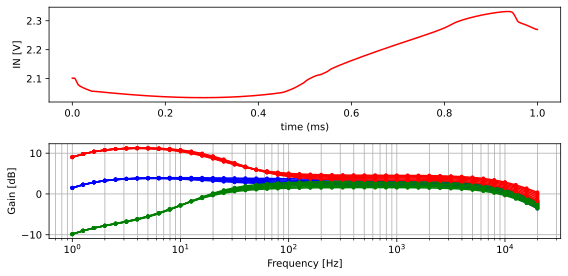

In [24]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_4'].abscissa), analysis['gate_out_4'], color='Red')

for f in buffer_data_lp :
    bode_diagram_gain(axe=ax2,
                    frequency=analysis_ac.frequency,
                    gain=20*np.log10(np.absolute(f)),
                    marker='.',
                    color='blue',
                    linestyle='-',
    )
for f in buffer_data_hp :
    bode_diagram_gain(axe=ax2,
                    frequency=analysis_ac.frequency,
                    gain=20*np.log10(np.absolute(f)),
                    marker='.',
                    color='green',
                    linestyle='-',
    )
for f in buffer_data_bp :
    bode_diagram_gain(axe=ax2,
                    frequency=analysis_ac.frequency,
                    gain=20*np.log10(np.absolute(f)),
                    marker='.',
                    color='red',
                    linestyle='-',
    )
#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()


## wasp like filter

In [25]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 1V SIN(0 1V 10)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)

# input
circuit.R(1, 'IN', 'rv1_out', 33@u_kΩ)
circuit.C(1, 'rv1_out', 'gate_in_1', 220@u_nF)

# 1st feedback
circuit.R(2, 'gate_in_1', 'gate_out_1', 33@u_kΩ ) #33@u_kΩ)

# 1st integrator
circuit.R(3, 'gate_out_1', 'gate_in_2', 10@u_kΩ)
circuit.C(2, 'gate_in_2', 'gate_out_2', 1@u_nF)

# second integrator
circuit.R(4, 'gate_out_2', 'gate_in_3', 10@u_kΩ)
circuit.C(3, 'gate_in_3', 'gate_out_3', 1@u_nF)

# feedback
circuit.C(5, 'gate_out_3', 'gate_in_1', 68@u_pF)
circuit.R(5, 'gate_out_3', 'gate_in_1', 33@u_kΩ)

circuit.R(6, 'gate_out_2', 'R5out', 1@u_kΩ)
circuit.R(7, 'R5out', 'gate_in_1', 33@u_kΩ)

print(circuit)

.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 1V SIN(0 1V 10)
X1 gate_in_1 gate_out_1 +5V 0 4069UB
X2 gate_in_2 gate_out_2 +5V 0 4069UB
X3 gate_in_3 gate_out_3 +5V 0 4069UB
R1 IN rv1_out 33kOhm
C1 rv1_out gate_in_1 220nF
R2 gate_in_1 gate_out_1 33kOhm
R3 gate_out_1 gate_in_2 10kOhm
C2 gate_in_2 gate_out_2 1nF
R4 gate_out_2 gate_in_3 10kOhm
C3 gate_in_3 gate_out_3 1nF
C5 gate_out_3 gate_in_1 68pF
R5 gate_out_3 gate_in_1 33kOhm
R6 gate_out_2 R5out 1kOhm
R7 R5out gate_in_1 33kOhm



In [26]:
#buffer_data_lp = []
#for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
#    circuit.Rv2.resistance = r
#    circuit.Rv3.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
#analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=100@u_ms);
#buffer_data_lp.append(np.array(analysis_ac['gate_out_3']))

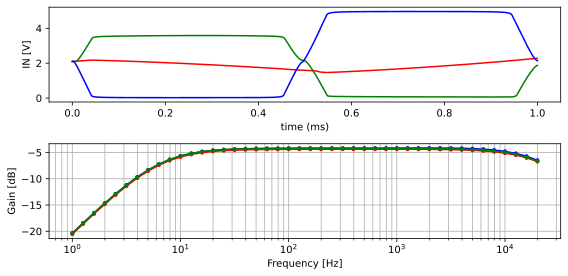

In [27]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_3'].abscissa), analysis['gate_out_3'], color='Red')
ax1.plot(u_ms(analysis['gate_out_2'].abscissa), analysis['gate_out_2'], color='Green')
ax1.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Blue')
#ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Red')

#for f in buffer_data_lp :
bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['gate_out_3']),
                marker='.',
                color='blue',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['gate_out_1']),
                marker='.',
                color='red',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['gate_out_2']),
                marker='.',
                color='green',
                linestyle='-',
)

#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()


## opamp svf

In [28]:
circuit = Circuit('opamp svf')
circuit.include(spice_library['TL072'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', 'TL072', 'X1p', 'X1n', '+15V', '-15V', 'X1out')
circuit.X('2', 'TL072', circuit.gnd, 'X2n', '+15V', '-15V', 'X2out')
circuit.X('3', 'TL072', circuit.gnd, 'X3n', '+15V', '-15V', 'X3out')

# input
circuit.R(1, 'IN', 'X1p', 1@u_kΩ)
circuit.R(2, 'X1p', 'X2out', 19@u_kΩ)
circuit.R(3, 'X1n', 'X1out', 10@u_kΩ)
circuit.R(4, 'X1n', 'X3out', 10@u_kΩ)

circuit.R('f1', 'X1out', 'X2n', 16@u_kΩ)
circuit.R('f2', 'X2out', 'X3n', 16@u_kΩ)

circuit.C('f1', 'X2n', 'X2out', 10@u_nF)
circuit.C('f2', 'X3n', 'X3out', 10@u_nF)

print(circuit)

.title opamp svf
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/TL072.lib
V1 +5V 0 DC 5
V2 +15V 0 DC 15
V3 -15V 0 DC -15
V4 IN 0 DC 5 AC 5V SIN(0 5V 1k)
X1 X1p X1n +15V -15V X1out TL072
X2 0 X2n +15V -15V X2out TL072
X3 0 X3n +15V -15V X3out TL072
R1 IN X1p 1kOhm
R2 X1p X2out 19kOhm
R3 X1n X1out 10kOhm
R4 X1n X3out 10kOhm
Rf1 X1out X2n 16kOhm
Rf2 X2out X3n 16kOhm
Cf1 X2n X2out 10nF
Cf2 X3n X3out 10nF



In [29]:
#buffer_data_lp = []
#for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
#    circuit.Rv2.resistance = r
#    circuit.Rv3.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms);
#buffer_data_lp.append(np.array(analysis_ac['gate_out_3']))

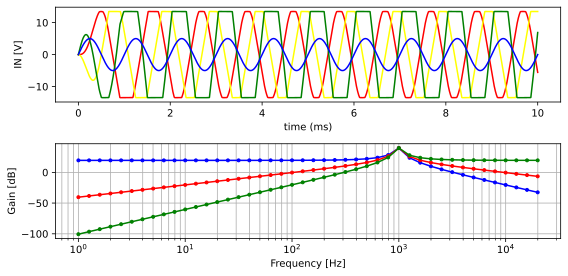

In [30]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['X3out'].abscissa), analysis['X3out'], color='Red')
ax1.plot(u_ms(analysis['X2out'].abscissa), analysis['X2out'], color='Yellow')
ax1.plot(u_ms(analysis['X1out'].abscissa), analysis['X1out'], color='Green')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='blue')

#for f in buffer_data_lp :
bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X3out']),
                marker='.',
                color='blue',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X2out']),
                marker='.',
                color='red',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X1out']),
                marker='.',
                color='green',
                linestyle='-',
)

#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

# test


In [31]:
circuit = Circuit('opamp svf')
circuit.include(spice_library['TL072'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'IN', circuit.gnd, 'DC 5 AC 1V SIN(0 1V 1k)')

circuit.X('1', 'TL072', 'X1p', 'X1n', '+15V', '-15V', 'X1out')
circuit.X('2', 'TL072', circuit.gnd, 'X2n', '+15V', '-15V', 'X2out')
circuit.X('3', 'TL072', circuit.gnd, 'X3n', '+15V', '-15V', 'X3out')

# input
circuit.R(1, 'IN', 'X1p', 1@u_kΩ)
circuit.R(2, 'X1p', 'X2out', 19@u_kΩ)
circuit.R(3, 'X1n', 'X1out', 10@u_kΩ)
circuit.R(4, 'X1n', 'X3out', 10@u_kΩ)

circuit.R('f1', 'X1out', 'X2n', 16@u_kΩ)
circuit.R('f2', 'X2out', 'X3n', 16@u_kΩ)

circuit.C('f1', 'X2n', 'X2out', 10@u_nF)
circuit.C('f2', 'X3n', 'X3out', 10@u_nF)

print(circuit)

.title opamp svf
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/TL072.lib
V1 +5V 0 DC 5
V2 +15V 0 DC 15
V3 -15V 0 DC -15
V4 IN 0 DC 5 AC 1V SIN(0 1V 1k)
X1 X1p X1n +15V -15V X1out TL072
X2 0 X2n +15V -15V X2out TL072
X3 0 X3n +15V -15V X3out TL072
R1 IN X1p 1kOhm
R2 X1p X2out 19kOhm
R3 X1n X1out 10kOhm
R4 X1n X3out 10kOhm
Rf1 X1out X2n 16kOhm
Rf2 X2out X3n 16kOhm
Cf1 X2n X2out 10nF
Cf2 X3n X3out 10nF



In [32]:
#buffer_data_lp = []
#for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
#    circuit.Rv2.resistance = r
#    circuit.Rv3.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms);
#buffer_data_lp.append(np.array(analysis_ac['gate_out_3']))

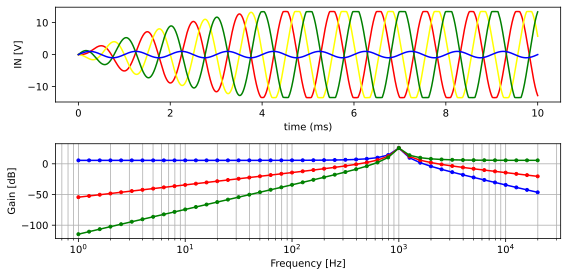

In [33]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['X3out'].abscissa), analysis['X3out'], color='Red')
ax1.plot(u_ms(analysis['X2out'].abscissa), analysis['X2out'], color='Yellow')
ax1.plot(u_ms(analysis['X1out'].abscissa), analysis['X1out'], color='Green')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='blue')

#for f in buffer_data_lp :
bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X3out']),
                marker='.',
                color='blue',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X2out']),
                marker='.',
                color='red',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X1out']),
                marker='.',
                color='green',
                linestyle='-',
)

#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## cmos svf

https://sound-au.com/articles/state-variable.htm

In [34]:
circuit = Circuit('cmos svf')

circuit.include(spice_library['4069UB'])
circuit.include(spice_library['TL072'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('0', 'TL072', circuit.gnd, 'X0n', '+15V', '-15V', 'X0out')
#circuit.X('1', 'TL072', circuit.gnd, 'X1n', '+15V', '-15V', 'X1out')
#circuit.X('2', 'TL072', circuit.gnd, 'X2n', '+15V', '-15V', 'X2out')
#circuit.X('3', 'TL072', circuit.gnd, 'X3n', '+15V', '-15V', 'X3out')

#circuit.X('0', '4069UB', 'X0n', 'X0out', '+5V', circuit.gnd)
circuit.X('1', '4069UB', 'X1n', 'X1out', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'X2n', 'X2out', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'X3n', 'X3out', '+5V', circuit.gnd)

#feedbacks
circuit.R(2, 'X0n', 'X0out', 100@u_kΩ)
circuit.C(1, 'X1n', 'X1out', 560@u_pF)
circuit.R(10, 'X0n', 'X0out', 50@u_kΩ)
circuit.C(2, 'X2n', 'X2out', 560@u_pF)
circuit.R(11, 'X2n', 'X2out', 50@u_kΩ)
circuit.R(8, 'X3n', 'X3out', 1000@u_kΩ)

# input
#circuit.C(3, 'IN', 'C3', 1@u_uF)
circuit.R(1, 'IN', 'X0n', 100@u_kΩ)

circuit.R(3, 'X0out', 'X1n', 100@u_kΩ)
circuit.R(9, 'X1out', 'X2n', 100@u_kΩ)


#resonance and feedback
circuit.R(4, 'X2out', 'X0n', 100@u_kΩ)

circuit.C(5, 'X1out', 'C5', 220@u_nF)
circuit.R(5, 'C5', 'X3n', 100@u_kΩ)

circuit.C(6, 'X3out', 'C6', 220@u_nF)
circuit.R(6, 'C6', 'X0n', 100@u_kΩ)

#out
#circuit.C(4, 'X2out', 'OUT', 1@u_uF)
#circuit.R(7, 'OUT', circuit.gnd, 100@u_kΩ)

print(circuit)

.title cmos svf
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/TL072.lib
V1 +5V 0 DC 5
V2 +15V 0 DC 15
V3 -15V 0 DC -15
V4 IN 0 DC 5 AC 2.5V SIN(0 2.5V 1k)
X0 0 X0n +15V -15V X0out TL072
X1 X1n X1out +5V 0 4069UB
X2 X2n X2out +5V 0 4069UB
X3 X3n X3out +5V 0 4069UB
R2 X0n X0out 100kOhm
C1 X1n X1out 560pF
R10 X0n X0out 50kOhm
C2 X2n X2out 560pF
R11 X2n X2out 50kOhm
R8 X3n X3out 1000kOhm
R1 IN X0n 100kOhm
R3 X0out X1n 100kOhm
R9 X1out X2n 100kOhm
R4 X2out X0n 100kOhm
C5 X1out C5 220nF
R5 C5 X3n 100kOhm
C6 X3out C6 220nF
R6 C6 X0n 100kOhm



In [35]:
#buffer_data_lp = []
#for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
#    circuit.Rv2.resistance = r
#    circuit.Rv3.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1000@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
#buffer_data_lp.append(np.array(analysis_ac['gate_out_3']))

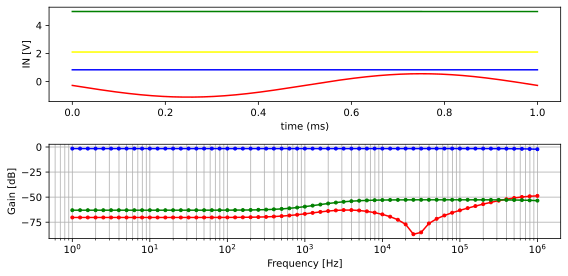

In [36]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['X3out'].abscissa), analysis['X0out'], color='Red')
ax1.plot(u_ms(analysis['X2out'].abscissa), analysis['X3out'], color='Yellow')
ax1.plot(u_ms(analysis['X1out'].abscissa), analysis['X1out'], color='Green')
ax1.plot(u_ms(analysis['X1out'].abscissa), analysis['X2out'], color='Blue')

#ax1.plot(u_ms(analysis['X3out'].abscissa), analysis['X3n'], color='Red')
#ax1.plot(u_ms(analysis['X2out'].abscissa), analysis['X2n'], color='Yellow')
#ax1.plot(u_ms(analysis['X1out'].abscissa), analysis['X1n'], color='Green')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Green')

#ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='blue')

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X2out']),
                marker='.',
                color='red',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X1out']),
                marker='.',
                color='green',
                linestyle='-',
)

bode_diagram_gain(axe=ax2,
                frequency=analysis_ac.frequency,
                gain=20*np.log10(analysis_ac['X0out']),
                marker='.',
                color='blue',
                linestyle='-',
)

#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## *references*

- [CD4069][1] Datasheet
